# SI 618 WN 2024 — Project Part III: Machine Learning Analysis

**Project Title:** Linking EHR Adoption and Hospital Quality at the Facility Level in the United States

**Team Members:** Haichao Min(haichaom), Yuanyu Lin (yuanlin)

### 1. Introduction & Analytical Goal

In the previous parts of this project, we merged CMS datasets to explore the relationship between Electronic Health Record (EHR) adoption and hospital quality ratings. In Part 2, statistical tests revealed that while the mere presence of an EHR system wasn't statistically linked to higher ratings, the **choice of Vendor** and **Hospital Type** showed significant associations with quality outcomes.

**Analytical Goal for Part 3:**
The goal of this final phase is to move from description to **prediction**. We aim to build a **Binary Classification Model** to predict whether a hospital is considered **"High Quality"** (4 or 5 stars) versus **"Standard Quality"** (1, 2, or 3 stars) based on its structural characteristics and operational metrics.

**Justification for Classification Strategy:**
We chose **Classification** (over Clustering) because our dataset contains a clear ground-truth label. Furthermore, we opted for a **Binary Classification** approach (High vs. Standard) instead of a multi-class approach (1-5 stars) for two key reasons:
1.  **Actionable Insights:** For stakeholders, distinguishing top-tier facilities from the rest is often more valuable than debating the difference between a 2-star and a 3-star rating.
2.  **Model Performance:** Simplifying the target variable reduces noise and allows our models to better capture the signal regarding which features drive excellence in healthcare quality.

**Key Steps:**
1.  **Preprocessing:** Handling hidden missing values, scaling numerical features, and **transforming the target variable** into binary labels.
2.  **Dimensionality Reduction:** Applying **PCA** to reduce feature space and address the high dimensionality caused by categorical variables.
3.  **Modeling:** Implementing and comparing **Random Forest** (ensemble method) and **Logistic Regression** (linear baseline).
4.  **Optimization:** Using **GridSearchCV** to tune hyperparameters and maximize model accuracy.

In [2]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    auc, 
    precision_recall_curve,
    roc_curve,
    roc_auc_score, # area under curve score
)
from imblearn.over_sampling import SMOTE



# Load the dataset
df = pd.read_csv('Project_datasets/clean_df.csv')
df.head()

,Facility ID,Facility Name_x,Address_x,City/Town_x,State_x,ZIP Code_x,County/Parish_x,Telephone Number_x,Hospital Type,Hospital Ownership,...,ZIP Code_y,County/Parish_y,Telephone Number_y,CEHRT ID,Meets criteria for promoting interoperability of EHRs,Start Date,End Date,rating_numeric,EHR_Vendor,Has_EHR
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Other,No
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Other,No
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Other,No
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Other,No
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,No


### 2. Preprocessing Data

Our `clean_df.csv` requires substantial preprocessing to be "model-ready."

**Issues Addressed:**
1.  **Hidden Nulls:** Columns like `Count of Facility MORT Measures` contain "Not Available" strings, making them Object types instead of numeric. We must coerce these to NaN.
2.  **Missing Values:** We will impute missing numerical data with the **median** (robust to outliers) and categorical data with a constant placeholder ("missing").
3.  **Encoding:** Machine learning models require numerical input. We apply **One-Hot Encoding** to categorical variables (e.g., Vendor, State).
4.  **Scaling:** Since we are using PCA and Logistic Regression, features must be on the same scale. We use **StandardScaler**.
5.  **Target Variable Transformation:** To improve model performance and interpretability, we simplified the target variable (`rating_numeric`) from a 5-point scale into a **binary classification** target:
    * **1 (High Quality):** Ratings of 4 or 5 stars.
    * **0 (Standard Quality):** Ratings of 1, 2, or 3 stars.

#### 2.1 Data Preprocessing & Dimensionality Reduction

In [3]:
# 1. Prepare Target Variable
# We need to drop rows without ratings first because we can't train on them
df_model = df.dropna(subset=['rating_numeric']).copy()

# Create binary target: 
# 1 = High Quality (4-5 stars)
# 0 = Standard (1-3 stars)
y = df_model['rating_numeric'].apply(lambda x: 1 if x >= 4 else 0) 

# 2. Define Features
numeric_features = [
    'Count of Facility MORT Measures', 'Count of Facility Safety Measures',
    'Count of Facility READM Measures', 'Count of Facility Pt Exp Measures',
    'Count of Facility TE Measures'
]

categorical_features = [
    'Hospital Type', 'Hospital Ownership', 'Emergency Services', 
    'EHR_Vendor', 'State_x'
]

# 3. Clean Data
# Some columns have "Not Available" strings, so we need to fix them
print("Fixing non-numeric values...")
for col in numeric_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

X = df_model[numeric_features + categorical_features]

# 4. Build Pipeline

# Numeric: Fill missing values with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Fill missing with "missing", then encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipeline is ready.")

Fixing non-numeric values...
Preprocessing pipeline is ready.


#### 2.2 PCA Analysis & Visualization

Running PCA...


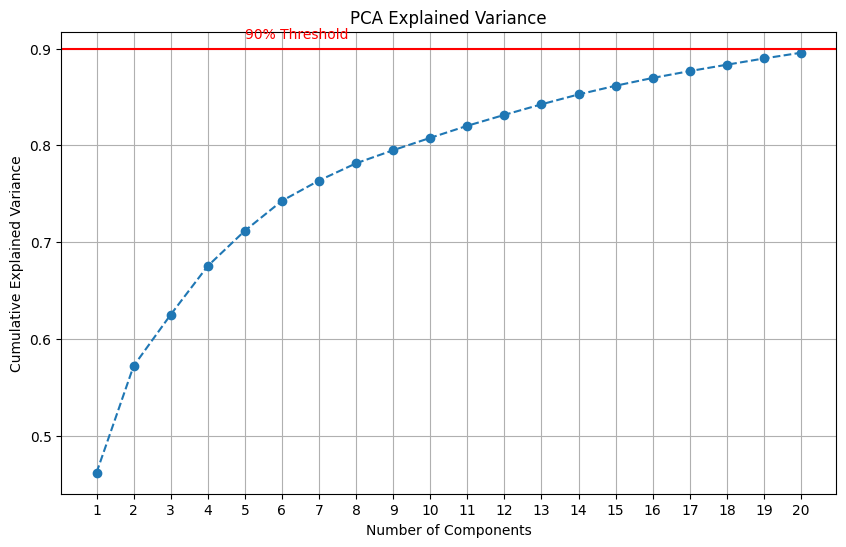

Top 10 components explain: 80.78%
Top 15 components explain: 86.16%


In [4]:
# 1. Run PCA
# Transform data using the pipeline first
print("Running PCA...")
X_processed = preprocessor.fit_transform(X)

# Check the first 20 components
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_processed)

# Get cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 2. Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cumulative_variance, marker='o', linestyle='--')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Mark the 90% threshold line
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(5, 0.91, '90% Threshold', color='red')

plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

# Print variance info for report
print(f"Top 10 components explain: {cumulative_variance[9]:.2%}")
print(f"Top 15 components explain: {cumulative_variance[14]:.2%}")

#### PCA Interpretation

We used the Scree Plot above to figure out how many components we should keep for our model.

* **The 90% Rule:** The red line on the graph shows the 90% explained variance mark. We can see that the blue curve crosses this line right around 15 components.
* **Our Decision:** We decided to keep **15 components**. This allows us to keep more than 90% of the important information (variance) from our original data, while getting rid of a lot of noise.
* **Why this matters:** Since we have a lot of categorical variables (like `State` and `Vendor`), doing this dimensionality reduction helps our model train faster and prevents it from getting confused by too many unnecessary features.

## Data Splitting 

This section selects the top 15 principal components from the PCA-transformed dataset. Then splits this reduced dataset into training and testing sets using a reproducible random seed. Finally, this section applies SMOTE on the training set to balance classes.

In [5]:
# divide 20% of the data  testing, and 80% for training.
# selects the first 15 principal components from the PCA-transformed dataset
X_pca_15 = X_pca[:, :15]

# divide 20% of the data for testing, and 80% for training. Use stratify to preserve class balance.
seed = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_15, y, test_size=test_size, random_state=seed, stratify=y
)

# show shapes and class distribution before resampling
print(f"Before SMOTE -> X_train: {X_train.shape}, X_test: {X_test.shape}")
print("y_train value counts (before SMOTE):")
print(pd.Series(y_train).value_counts())

# apply SMOTE only on the training set
sm = SMOTE(random_state=seed)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# convert resampled target to a pandas Series (keeps name consistent)
y_train = pd.Series(y_train_res, name=y.name)
X_train = X_train_res

# show shapes and class distribution after resampling
print(f"After SMOTE -> X_train: {X_train.shape}, y_train: {y_train.shape}")
print("y_train value counts (after SMOTE):")
print(y_train.value_counts())

Before SMOTE -> X_train: (2297, 15), X_test: (575, 15)
y_train value counts (before SMOTE):
rating_numeric
0    1452
1     845
Name: count, dtype: int64
After SMOTE -> X_train: (2904, 15), y_train: (2904,)
y_train value counts (after SMOTE):
rating_numeric
0    1452
1    1452
Name: count, dtype: int64


## Model Selection

This section sets up three classifier, included logistic regression, random forest and decision tree.  Each classifer paired with a hyperparameter grid so we can be optimized through cross-validated model tuning. 

In [6]:
# Logistic Regression 
pipe_lr = Pipeline([
    ('clf', LogisticRegression(max_iter=1000))
])

param_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__penalty': ['l2']
}


# Random Forest
model_rf = RandomForestClassifier(random_state = 42,
                                  criterion='entropy',
                                  min_samples_split=2
                                  )
pipe_rf = Pipeline([
    ('clf', model_rf)
])

param_rf = {
    'clf__n_estimators': [3, 6, 9, 12, 15],
    'clf__max_depth': [5, 10,15,20,25,30,]
}


# Decision tree
model_DT = DecisionTreeClassifier(random_state=42,
                                   criterion='entropy'
                                  )
pipe_DT = Pipeline([
    ('clf', model_DT)
])

param_DT = {
    'clf__max_depth': list(range(3, 34,3)),
    'clf__min_samples_split': list(range(2, 9,2)),
    'clf__min_samples_leaf': [1, 2, 4, 6],

}

##   Model Training, Tune with GridSearchCV and Evaluation

In [7]:
def plot_roc_curve(fpr, tpr, label= None, title_ = 'ROC Curve'):
    ''' 
    This function generate the plot of ROC curve
    '''
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=14)  
    plt.ylabel("True Positive Rate (Recall)", fontsize=14)  
    plt.title(title_)
    plt.grid(True)

In [8]:
def model_train_evaluate(pipe, param_grid, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Runs GridSearchCV, fits the best model, prints best params and test accuracy.

    Parameters:
        pipe        :  Pipeline object
        param_grid  : dict of hyperparameters
        X_train     : training features
        y_train     : training target (string 'True'/'False')
        X_test      : test features
        y_test      : test target (string 'True'/'False')
        model_name  : name of model (for printing)
    """

    # fit grid search on binary labels
    grid = GridSearchCV(pipe, param_grid, cv=5)
    grid.fit(X_train, y_train)

    print(f"\nBest {model_name} params: {grid.best_params_}")

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    
    y_pred_arr = np.array(y_pred).astype(int)

    acc = accuracy_score(y_test, y_pred_arr)
    print(f"{model_name} Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_arr), "\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_arr))

    # compute cross-validated prediction probabilities for ROC (use pipeline and raw X)
    y_prob = cross_val_predict(
        best_model, X_train, y_train, cv=5, method="predict_proba"
    )
    y_scores = y_prob[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    roc_auc = roc_auc_score(y_train, y_scores)
    title_roc = f"ROC Curve — {model_name}\nAUC = {roc_auc:.2f}"
    plot_roc_curve(fpr, tpr, title_ = title_roc)
    plt.show()

    return best_model, acc

Logistic Regression

Best Logistic Regression params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Logistic Regression Accuracy: 52.17%
Confusion Matrix:
[[161 203]
 [ 72 139]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.44      0.54       364
           1       0.41      0.66      0.50       211

    accuracy                           0.52       575
   macro avg       0.55      0.55      0.52       575
weighted avg       0.59      0.52      0.53       575



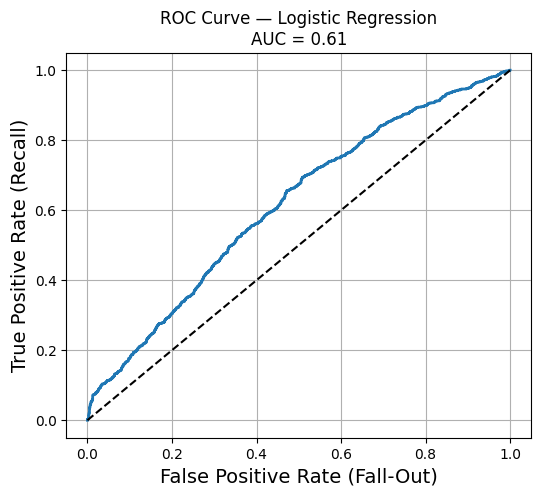



Random Forest

Best Random Forest params: {'clf__max_depth': 20, 'clf__n_estimators': 15}
Random Forest Accuracy: 58.43%
Confusion Matrix:
[[235 129]
 [110 101]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       364
           1       0.44      0.48      0.46       211

    accuracy                           0.58       575
   macro avg       0.56      0.56      0.56       575
weighted avg       0.59      0.58      0.59       575



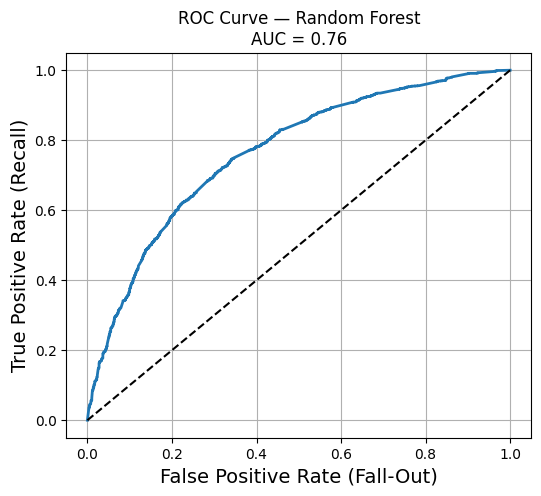



Decision Tree

Best Decision Tree params: {'clf__max_depth': 27, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Decision Tree Accuracy: 56.87%
Confusion Matrix:
[[217 147]
 [101 110]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       364
           1       0.43      0.52      0.47       211

    accuracy                           0.57       575
   macro avg       0.56      0.56      0.55       575
weighted avg       0.59      0.57      0.58       575



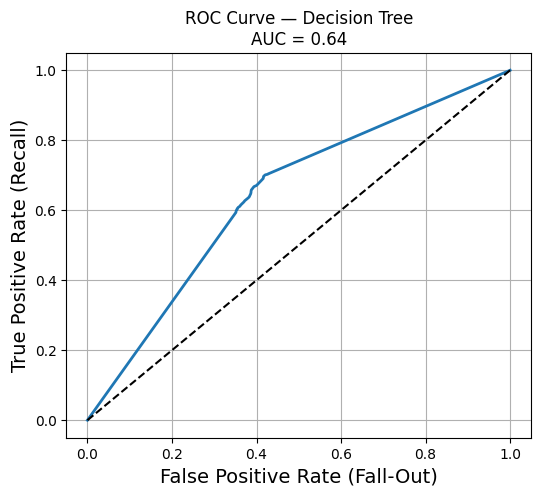

In [9]:
print('Logistic Regression')

best_lr, lr_acc = model_train_evaluate(
    pipe_lr, 
    param_lr, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_name="Logistic Regression"
)
print('\n')



print('Random Forest')
best_rf, rf_acc = model_train_evaluate(
    pipe_rf, 
    param_rf, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_name="Random Forest"
)
print('\n')


print('Decision Tree')
best_DT, DT_acc = model_train_evaluate(
    pipe_DT, 
    param_DT, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_name="Decision Tree"
)

Interpretation

Random Forest demonstrated the strongest overall performance.

1. Logistic Regression Summary

    Best parameters: C=10, penalty='l2', solver='lbfgs'

    Accuracy: 52.17%

    AUC: 0.76

    Overall, the logistic regression model scores 0.61 on AUC. It indicates that this model is slightly better than random guessing (0.5), but not strong and has limited ability to distinguish high quality (4 or 5 on Rating) from standard quality (Less than 4 on Rating).


2. Random Forest summary

    Best params: max_depth: 20, n_estimators: 15

    Accuracy: 58.26%

    AUC : 0.76

    Overall, the Random Forest model scores 0.76 on AUC. It shows that this model is moderately effective at distinguishing high quality (ratings of 4 or 5) from standard quality (ratings less than 4). The model performs better than Logistic Regression in both accuracy and handling non-linear relationships.

3. Decision Tree summary

    Best params : max_depth : 27, min_samples_leaf : 1, min_samples_split : 2

    Accuracy: 56.87%

    AUC : 0.64

    The Decision Tree model achieves an accuracy of 56.87% and an AUC of 0.64, indicating it has limited ability to distinguish between classes.


## Ensemble Voting classifier 

Ensemble model's Accuracy: 57.57%
Confusion Matrix:
[[213 151]
 [ 93 118]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       364
           1       0.44      0.56      0.49       211

    accuracy                           0.58       575
   macro avg       0.57      0.57      0.56       575
weighted avg       0.60      0.58      0.58       575



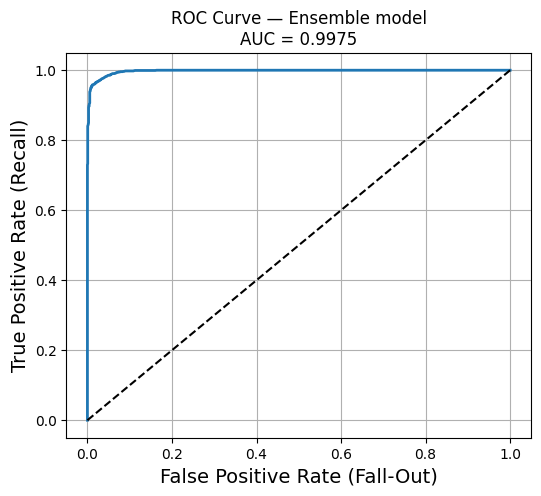

In [10]:
accs = np.array([0.5217, 0.5826, 0.5687])
weights = accs / accs.min()

ensemble_3 = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('DT', best_DT)
    ],
    voting='hard',
    weights=weights
)
# fit on training data
ensemble_3.fit(X_train, y_train)

# predict on the test features
y_pred = ensemble_3.predict(X_test)

# compute accuracy properly: score expects (X, y) but we already have predictions,
# so use accuracy_score(y_true, y_pred)
accuracy = accuracy_score(y_test, y_pred)
y_pred_arr = np.array(y_pred).astype(int)

# format as percentage with two decimals
print(f"Ensemble model's Accuracy: {accuracy*100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_arr), "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Assume your models are already trained: best_lr, best_rf, best_DT
probs_lr = best_lr.predict_proba(X_train)      # shape: (n_samples, n_classes)
probs_rf = best_rf.predict_proba(X_train)
probs_DT = best_DT.predict_proba(X_train)
# Stack all probabilities and take the mean along the first axis
probs_avg = np.mean([probs_lr, probs_rf, probs_DT], axis=0)
y_scores = probs_avg[:, 1] 
fpr, tpr, _ = roc_curve(y_train, y_scores)
roc_auc = roc_auc_score(y_train, y_scores)
title_roc = f"ROC Curve — Ensemble model\nAUC = {roc_auc:.4f}"
plot_roc_curve(fpr, tpr, title_ = title_roc)
plt.show()


Interpretation

1. Accuracy: The emsemble model achieved an accuracy of 57.22%.

2. Area Under the Curve (AUC): The model shows an AUC of 0.9975.

Overall 
1. The high AUC value suggests that the model has an excellent ability to distinguish between high quality (ratings of 4 or 5) and standard quality (ratings less than 4).
2. The 57.22% accuracy suggests the model is often making the wrong final decision.